# Setup and install for MNIST

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pip install progressbar

  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=015870793bade22921ac2ba23a5a93aae7a3aca607ad59528a0ce7a289e8d940
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar


In [ ]:
%pip install gpflow
%pip install plotnine

     |████████████████████████████████| 287 kB 15.0 MB/s 
     |████████████████████████████████| 462 kB 84.6 MB/s 


In [ ]:
from plotnine import *
from plotnine.themes import *

In [ ]:
import tensorflow as tf
from scipy.io import loadmat
import random
import math
import tensorflow_probability as tfp

_paper_name_ establishes the reusable name of the paper, it represents the directory under data_papers on the google drive

In [ ]:
paper_name = "mnist"

In [ ]:
import os, sys
import errno

# make a directory if it does not exist
def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')

# make directories if they do not exist

make_dir_if_not_exist("/content/drive/MyDrive/data_papers/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_predictions/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/temp/")


Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.<br />
The below ```featch_mldata``` method to load MNIST returns ```data``` and ```target``` as ```uint8``` which we convert to ```float32``` and ```int64``` respectively.

The bibtex reference is:

@article{deng2012mnist,
  title={The mnist database of handwritten digit images for machine learning research},
  author={Deng, Li},
  journal={IEEE Signal Processing Magazine},
  volume={29},
  number={6},
  pages={141--142},
  year={2012},
  publisher={IEEE}
} 



In [ ]:
# Set up the imports
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Concatenate, Add, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np

import site
import os
import tensorflow as tf
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import errno
import numpy as np
import itertools
import multiprocessing
import json
import datetime
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import  Dense, Flatten, Activation, Dropout, Embedding, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Concatenate, BatchNormalization, GaussianNoise, AveragePooling2D
from tensorflow.keras.layers import LSTM, TimeDistributed, Permute, Reshape, Lambda, RepeatVector, Input, Multiply, SimpleRNN, GRU, LeakyReLU, Add
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.summary import create_file_writer

pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 40)


In [ ]:
# %pip install RMDL

In [ ]:
# Run this cell to load the dataset 
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

mnist = fetch_openml('mnist_784', cache=False)
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X /= 255.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    idx = X.sample(5).index
    for i, (img, y) in enumerate(zip(X.loc[idx].to_numpy().reshape(5, 28, 28), y.loc[idx])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

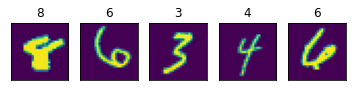

In [ ]:
plot_example(X_train, y_train)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Rescale the images from [0,255] to the [0.0,1.0] range.
X_train, X_test = X_train[..., np.newaxis]/255.0, X_test[..., np.newaxis]/255.0
X_validation = X_validation[..., np.newaxis]/255.0

# print("Number of original training examples:", len(x_train))
# print("Number of original test examples:", len(x_test))

print( X_train.shape, X_validation.shape, X_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
(54000, 28, 28, 1) (6000, 28, 28, 1) (10000, 28, 28, 1)


In [ ]:
# np.unique(y_train.head(100))
paper_name

'mnist'

In [ ]:
train_data = X_train
validation_data = X_validation
test_data = X_test
train_targets = y_train
validation_targets = y_validation
test_targets = y_test

In [ ]:
# extracts the layer from a model using the name
def get_layer_by_name(layers, name, return_first=True):
    matching_named_layers = [l for l in layers if l.name == name]
    if not matching_named_layers:
        return None
    return matching_named_layers[0] if return_first else matching_named_layers


In [ ]:
# plotting utilities for the history of the fit
def plot_history(history):
    acc_keys = [k for k in history.history.keys() if 'accuracy' in k]
    loss_keys = [k for k in history.history.keys() if not k in acc_keys]
    for k, v in history.history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        else:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()

def plot_history_df(history):
    acc_keys = [k for k in history.columns.values if 'accuracy' in k]
    loss_keys = [k for k in history.columns.values if not k in acc_keys and not k in ['epoch']]
    for k, v in history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        if k in loss_keys:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()   


A function that will take a model construction function (with _model_name_ and _input_shape_ arguments), train and fit it using the supplied data and callbacks. The _kwargs_ are supplied to the model fit function.

In [ ]:
from tensorflow.keras.callbacks import CSVLogger
import datetime

def compile_and_fit_model_basic(  model_func,
                                  model_name,
                                  input_shape,
                                  X_train,
                                  Y_train,
                                  save_max_epoch=True,
                                  save_final=False,
                                  patience_count = None,
                                  early_stopping_obs = 'val_categorical_accuracy',
                                  log_history = True,
                                  verbose_level = 0,
                                  **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
      
    if 'validation_data' not in kwargs.keys() and 'val_' in early_stopping_obs:
        early_stopping_obs = early_stopping_obs.replace('val_','')

    callbacks_used = []
    if save_max_epoch:
        callbacks_used.append(ModelCheckpoint(f'/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/{m.name}' + '_model_{epoch:03d}_{accuracy:0.3f}',
                                              save_weights_only=False,
                                              monitor = early_stopping_obs,
                                              mode='max',
                                              save_best_only=True))
    if patience_count is not None:
        callbacks_used.append(tf.keras.callbacks.EarlyStopping(monitor=early_stopping_obs, patience=patience_count))

    if log_history:
        callbacks_used.append(tf.keras.callbacks.CSVLogger(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/history_log_{model_name}_{datetime.date.today().strftime('%Y%m%d')}.csv", append=True))

    m.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

    # m.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    #           optimizer=tf.keras.optimizers.Adam(), 
    #           metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
# model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

    history = m.fit(X_train, Y_train, callbacks=callbacks_used, verbose=verbose_level, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)

Some functions to get scores on the results

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import re

def get_confusion_matrix_classification(model, X, Y_true):
    y_pred = model.predict(X)
    y_true = np.apply_along_axis(np.argmax, 1, Y_true)
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def construct_confusion_matrix(X, Y_true, Y_pred):
    y_true = Y_true
    y_pred = np.apply_along_axis(np.argmax, 1, Y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def pr_rc_f1_acc_from_supplied(y_pred, y_true):  
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")   
    acc = accuracy_score(y_true, y_pred)
    return pr, rc, f1, acc


In [ ]:
import re
import os

def dir_has_file_with_regex(dir_name, regex_string):
  filenames = [ f"{dir_name}/{dir_entry.name}" for dir_entry in os.scandir(dir_name) if os.path.isfile(f"{dir_name}/{dir_entry.name}") ]   
  filenames = [ fn for fn in filenames if re.match(regex_string, fn, re.IGNORECASE) ]
  return filenames


In [ ]:
# dir_has_file_with_regex("/content/drive/MyDrive/data_papers/gpSVHN/model_features", "^.*DNN_A_.*D3R_Test_X.*")

In [ ]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-f919a523-cabc-f644-d790-821b15460850)


In [ ]:
!pip install ipython-autotime

In [ ]:
%load_ext autotime

time: 119 µs (started: 2022-02-24 11:00:54 +00:00)


In [ ]:
import timeit

time: 732 µs (started: 2022-02-24 11:00:54 +00:00)


# Imports

In [ ]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
AUTOTUNE = tf.data.AUTOTUNE
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0
time: 23.6 ms (started: 2022-02-24 11:00:54 +00:00)


In [ ]:
#title visualization utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  for validation_digits, validation_labels in validation_dataset:
    validation_digits = validation_digits.numpy()
    validation_labels = validation_labels.numpy()
    break
  for training_digits, training_labels in batch_train_ds:
    training_digits = training_digits.numpy()
    training_labels = training_labels.numpy()
    break
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)
    
# utility to display training and validation curves
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.grid(linewidth=1, color='white')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

time: 87.5 ms (started: 2022-02-24 11:00:54 +00:00)


# TPU or GPU detection

In [ ]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of accelerators:  1
time: 2.78 s (started: 2022-02-24 11:00:54 +00:00)


# Parameters for CNN/DNN runs

In [ ]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync # Gobal batch size.
# The global batch size will be automatically sharded across all
# replicas by the tf.data.Dataset API. A single TPU has 8 cores.
# The best practice is to scale the batch size by the number of
# replicas (cores). The learning rate should be increased as well.

LEARNING_RATE = 0.01
LEARNING_RATE_EXP_DECAY = 0.6 if strategy.num_replicas_in_sync == 1 else 0.7
# Learning rate computed later as LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch
# 0.7 decay instead of 0.6 means a slower decay, i.e. a faster learnign rate.

training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

NameError: ignored

# tf.data.Dataset: parse files and prepare training and validation datasets
Please read the [best practices for building](https://www.tensorflow.org/guide/performance/datasets) input pipelines with tf.data.Dataset

In [ ]:
def read_label(tf_bytestring):
    label = tf.io.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label
  
def read_image(tf_bytestring):
    image = tf.io.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image
  
def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
  
def get_training_validation_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM
    # dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat()      # the batching will repeat infinitely if you keep doing this... bad for the features...
    validation_dataset = dataset.take(10000) 
    train_dataset = dataset.skip(10000)
    validation_dataset = validation_dataset.batch(batch_size)
    validation_dataset = validation_dataset.prefetch(AUTOTUNE)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.prefetch(AUTOTUNE)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return train_dataset, validation_dataset
  
def get_test_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache() # this small dataset can be entirely cached in RAM
    dataset = dataset.batch(10000)
    return dataset

def get_training_validation_dataset_unrepeat(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM
    # dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    # dataset = dataset.repeat()      # the batching will repeat infinitely if you keep doing this... bad for the features...
    validation_dataset = dataset.take(10000) 
    train_dataset = dataset.skip(10000)
    validation_dataset = validation_dataset.batch(batch_size)
    validation_dataset = validation_dataset.prefetch(AUTOTUNE)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.prefetch(AUTOTUNE)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return train_dataset, validation_dataset

# def get_training_validation_dataset_unrepeat_rotate(image_file, label_file, batch_size):
#     dataset = load_dataset(image_file, label_file)
#     dataset = dataset.cache()  # this small dataset can be entirely cached in RAM
#     # dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
#     # dataset = dataset.repeat()      # the batching will repeat infinitely if you keep doing this... bad for the features...
#     validation_dataset = dataset.take(10000) 
#     train_dataset = dataset.skip(10000)
#     validation_dataset = validation_dataset.batch(batch_size)
#     # tf.contrib.image.rotate(images, degrees * math.pi / 180, interpolation='BILINEAR')

#     validation_dataset = validation_dataset.prefetch(AUTOTUNE)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
#     train_dataset = train_dataset.batch(batch_size)
#     train_dataset = train_dataset.prefetch(AUTOTUNE)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
#     return train_dataset, validation_dataset


# def get_full_training_mnist():
#     dataset = load_dataset(training_images_file, training_labels_file)
#     dataset = dataset.cache()  # this small dataset can be entirely cached in RAM
#     dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
#     dataset = dataset.repeat()
#     validation_dataset = dataset.take(10000) 
#     train_dataset = dataset.skip(10000)

# instantiate the datasets
training_dataset, validation_dataset = get_training_validation_dataset(training_images_file, training_labels_file, BATCH_SIZE)
test_dataset = get_test_dataset(validation_images_file, validation_labels_file)



time: 266 ms (started: 2022-02-24 11:00:57 +00:00)


In [ ]:
training_dataset_full, test_dataset_full = get_training_validation_dataset(training_images_file, training_labels_file, BATCH_SIZE)

time: 34 ms (started: 2022-02-24 11:00:57 +00:00)


# Let's have a look at the data

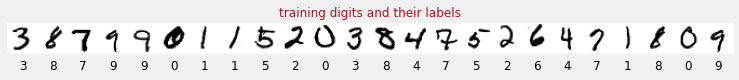

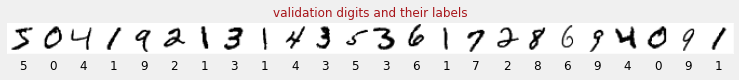

time: 3.43 s (started: 2022-02-24 11:00:58 +00:00)


In [ ]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

# Function for writing the features and getting (un)batched data sets to be used

A function that given a model or model directory create a new model up to the _layer_name_, then write the features matching the supplied _X_ and _Y_ as numpy arrays to google drive.

In [ ]:
# note the removal of the Y feature writing...
def write_features_from_models(
        model_entry,
        layer_name,
        data_set_input,
        normalize_X_func=None,
        dataset_id = "NA",
        **kwargs):
  
    model_here = None
    if isinstance(model_entry, tf.keras.models.Model):
        model_here = model_entry
        model_file_name = model_here.name
    else:
        model_here = tf.keras.models.load_model(model_entry,**kwargs) 

    features_model = Model(model_here.input,
                            get_layer_by_name(model_here.layers, layer_name).output)
    if normalize_X_func is None:
        X_new = np.array(features_model.predict(data_set_input), dtype='float64')
    else:
        X_new = np.array(normalize_X_func(features_model.predict(data_set_input)), dtype='float64')

    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_X", X_new, 
               allow_pickle=True, 
               fix_imports=True)
    

time: 8.16 ms (started: 2022-01-26 16:15:23 +00:00)


In [ ]:
## TOO SLOW do NOT do this

# train_ds_unbatched = training_dataset.unbatch()
# validation_ds_unbatched = validation_dataset.unbatch()
# test_ds_unbatched = test_dataset.unbatch()

# train_X_images = np.asarray(list(train_ds_unbatched.map(lambda x, y: x)))
# train_Y_labels = np.asarray(list(train_ds_unbatched.map(lambda x, y: y)))

# validation_X_images = np.asarray(list(validation_ds_unbatched.map(lambda x, y: x)))
# validation_Y_labels = np.asarray(list(validation_ds_unbatched.map(lambda x, y: y)))

# test_X_images = np.asarray(list(test_ds_unbatched.map(lambda x, y: x)))
# test_Y_labels = np.asarray(list(test_ds_unbatched.map(lambda x, y: y)))

time: 1.65 ms (started: 2022-01-26 16:15:24 +00:00)


In [ ]:
def unbatch_dataset_in_two(input_dataset):

  images = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  labels = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)

  for x, y in input_dataset.unbatch():
    images = images.write(images.size(), x)
    labels = labels.write(labels.size(), y)

  images = tf.stack(images.stack(), axis=0)
  labels = tf.stack(labels.stack(), axis=0)

  return (images.numpy(), labels.numpy())


time: 4.65 ms (started: 2022-01-26 16:15:24 +00:00)


In [ ]:
training_dataset_unrepeat, validation_dataset_unrepeat = get_training_validation_dataset_unrepeat(training_images_file, training_labels_file, BATCH_SIZE)
test_X_images, test_Y_labels = unbatch_dataset_in_two(test_dataset)
validation_X_images, validation_Y_labels = unbatch_dataset_in_two(validation_dataset_unrepeat)
train_X_images, train_Y_labels = unbatch_dataset_in_two(training_dataset_unrepeat)  

time: 30.1 s (started: 2022-01-26 16:15:24 +00:00)


In [ ]:
print(train_X_images.shape, validation_X_images.shape, test_X_images.shape)
test_Y_labels = test_Y_labels.astype('int32')
validation_Y_labels = validation_Y_labels.astype('int32')
train_Y_labels = train_Y_labels.astype('int32')

test_Y_labels_as_numbers = np.apply_along_axis(np.argmax, 1, test_Y_labels)

(50000, 784) (10000, 784) (10000, 784)
time: 45.9 ms (started: 2022-01-26 16:15:54 +00:00)


# MNIST base CNN full data set

https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/01_MNIST_TPU_Keras.ipynb#scrollTo=56y8UNFQIVwj

In [ ]:
def mnist_baseCNN_model(model_name):
    model = tf.keras.Sequential(
      [
        tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1), name="image"),

        tf.keras.layers.Conv2D(filters=12, kernel_size=3, padding='same', use_bias=False), # no bias necessary before batch norm
        tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        tf.keras.layers.Activation('relu'), # activation after batch norm

        tf.keras.layers.Conv2D(filters=24, kernel_size=6, padding='same', use_bias=False, strides=2),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(filters=32, kernel_size=6, padding='same', use_bias=False, strides=2),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(200, use_bias=False, name="LD1"),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.4), # Dropout on dense layer only

        tf.keras.layers.Dense(10, activation='softmax', name="SFTMX")
      ])

    model._name = model_name
     # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
    return model



time: 18.8 ms (started: 2022-01-24 19:14:05 +00:00)


In [ ]:
def mnist_baseCNN_rotate_model(model_name):
    model = tf.keras.Sequential(
      [
        tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1), name="image"),
        tf.keras.layers.RandomRotation(20),  
        tf.keras.layers.Conv2D(filters=12, kernel_size=3, padding='same', use_bias=False), # no bias necessary before batch norm
        tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        tf.keras.layers.Activation('relu'), # activation after batch norm

        tf.keras.layers.Conv2D(filters=24, kernel_size=6, padding='same', use_bias=False, strides=2),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(filters=32, kernel_size=6, padding='same', use_bias=False, strides=2),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(200, use_bias=False, name="LD1"),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.4), # Dropout on dense layer only

        tf.keras.layers.Dense(10, activation='softmax', name="SFTMX")
      ])

    model._name = model_name
     # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
    return model

time: 18.5 ms (started: 2022-01-24 20:32:13 +00:00)


In [ ]:
EPOCHS = 250
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=False)

for model_count in [i+1 for i in range(2)]:
  start_time = timeit.default_timer()
  # model_name = f"FULLCONVNN_MNIST_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}"
  # m = mnist_baseCNN_model(model_name)
  model_name = f"FULLCONVNNROT20_MNIST_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}"
  m = mnist_baseCNN_rotate_model(model_name)
  print(m.name)
  m.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  history = m.fit(training_dataset_full,
                      steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                      validation_steps=1, verbose=1,
                      callbacks=[lr_decay])
  print(timeit.default_timer()-start_time)
  m.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{m.name}_saved_model_after_fit")  # Save the model

In [ ]:
# m.predict(validation_dataset)
# m.predict(test_dataset)
m.evaluate(test_X_images, test_Y_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.0555 - accuracy: 0.9820


[0.055545177310705185, 0.9819999933242798]

time: 1 s (started: 2022-01-24 20:52:46 +00:00)


# MNIST base CNN

https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/01_MNIST_TPU_Keras.ipynb#scrollTo=56y8UNFQIVwj

In [ ]:
def mnist_baseCNN_model(model_name):
    model = tf.keras.Sequential(
      [
        tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1), name="image"),

        tf.keras.layers.Conv2D(filters=12, kernel_size=3, padding='same', use_bias=False), # no bias necessary before batch norm
        tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        tf.keras.layers.Activation('relu'), # activation after batch norm

        tf.keras.layers.Conv2D(filters=24, kernel_size=6, padding='same', use_bias=False, strides=2),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(filters=32, kernel_size=6, padding='same', use_bias=False, strides=2),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(200, use_bias=False, name="LD1"),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.4), # Dropout on dense layer only

        tf.keras.layers.Dense(10, activation='softmax', name="SFTMX")
      ])

    model._name = model_name
     # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
    return model



time: 19.6 ms (started: 2022-01-22 18:11:12 +00:00)


In [ ]:
EPOCHS = 20
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=False)

for model_count in [i+2 for i in range(40)]:
  start_time = timeit.default_timer()
  model_name = f"CNN_MNIST_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}"
  m = mnist_baseCNN_model(model_name)
  print(m.name)
  m.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  history = m.fit(training_dataset,
                      steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                      validation_data=validation_dataset, validation_steps=1, verbose=0,
                      callbacks=[lr_decay])
  print(timeit.default_timer()-start_time)
  m.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{m.name}_saved_model_after_fit")  # Save the model

In [ ]:
# m.predict(validation_dataset)
# m.predict(test_dataset)

In [ ]:
# write training features
check_model_string = "CNN_MNIST_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_DRP1_Train.*$"):
        print(dir_entry.name)
        write_features_from_models(
              f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
              "LD1",
              train_X_images,
              normalize_X_func=None,
              dataset_id = "Train")
        write_features_from_models(
              f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
              "SFTMX",
              train_X_images,
              normalize_X_func=None,
              dataset_id = "Train")


In [ ]:
# write validation features
check_model_string = "CNN_MNIST_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_DRP1_Train.*$"):
        print(dir_entry.name)
        write_features_from_models(
              f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
              "LD1",
              validation_X_images,
              normalize_X_func=None,
              dataset_id = "Validation")
        write_features_from_models(
              f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
              "SFTMX",
              validation_X_images,
              normalize_X_func=None,
              dataset_id = "Validation")
          
        

In [ ]:
# write test features
check_model_string = "CNN_MNIST_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_DRP1_Train.*$"):
        print(dir_entry.name)
        write_features_from_models(
              f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
              "LD1",
              test_X_images,
              normalize_X_func=None,
              dataset_id = "Test")
        write_features_from_models(
              f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
              "SFTMX",
              test_X_images,
              normalize_X_func=None,
              dataset_id = "Test")


# MNIST Base DNN

In [ ]:
def get_mnist_dnn(model_name, input_size = 784, hidden_neurons = 400, classes =10):
  model = Sequential()     
  model.add(Dense(hidden_neurons, input_dim=input_size, activation='relu', name="LD1")) 
  model.add(Dense(classes, input_dim=hidden_neurons, activation='softmax', name="SFTMX")) 
  model._name = model_name
  return model


time: 2.91 ms (started: 2022-01-24 15:12:47 +00:00)


In [ ]:
EPOCHS = 15
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=False)

for model_count in [i+1 for i in range(80)]:
  start_time = timeit.default_timer()
  model_name = f"DNN_MNIST_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}"
  m = get_mnist_dnn(model_name)
  print(m.name)
  m.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  history = m.fit(training_dataset,
                      steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                      validation_data=validation_dataset, validation_steps=1, verbose=0,
                      callbacks=[lr_decay])
  print(timeit.default_timer()-start_time)
  m.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{m.name}_saved_model_after_fit")  # Save the model

In [ ]:
# write training features
check_model_string = "DNN_MNIST_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_DRP1_Train.*$"):
        print(dir_entry.name)
        write_features_from_models(
              f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
              "LD1",
              train_X_images,
              normalize_X_func=None,
              dataset_id = "Train")
        write_features_from_models(
              f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
              "SFTMX",
              train_X_images,
              normalize_X_func=None,
              dataset_id = "Train")


In [ ]:
# write validation features
check_model_string = "DNN_MNIST_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_DRP1_Train.*$"):
        print(dir_entry.name)
        write_features_from_models(
              f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
              "LD1",
              validation_X_images,
              normalize_X_func=None,
              dataset_id = "Validation")
        write_features_from_models(
              f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
              "SFTMX",
              validation_X_images,
              normalize_X_func=None,
              dataset_id = "Validation")
          
        

In [ ]:
# write test features
check_model_string = "DNN_MNIST_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_DRP1_Train.*$"):
        print(dir_entry.name)
        write_features_from_models(
              f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
              "LD1",
              test_X_images,
              normalize_X_func=None,
              dataset_id = "Test")
        write_features_from_models(
              f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
              "SFTMX",
              test_X_images,
              normalize_X_func=None,
              dataset_id = "Test")


In [ ]:
# getting the scores for the individual DNNs on the test data set
scores_dnn_simple = []
check_model_string = "DNN_MNIST_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      print(dir_entry.name)
      # model_here = tf.keras.models.load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}")  
      # y_predict_here = np.array(model_here.predict(test_data_grey), dtype='float64')
      # y_predict_here = np.apply_along_axis(np.argmax, 1, y_predict_here)
      # scores_dnn_simple.append(pr_rc_f1_acc_from_supplied(y_predict_here, test_targets))

# np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_dnn_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_dnn_simple), 
#                allow_pickle=True, 
#                fix_imports=True)

# Create summary data for CNN/DNN




In [ ]:
# getting the scores for the individual DNNs on the test data set
scores_dnn_simple = []
check_model_string = "DNN_MNIST_"
not_check_model_string = ["arallel","Collab_"]

dir_entries = os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/")
dir_entries = [ de for de in list(dir_entries) if os.path.isdir(de) and check_model_string in de.name and all([ (not ncs in de.name) for ncs in not_check_model_string]) ]

for dir_entry in dir_entries:
  print(dir_entry.name)
  model_here = tf.keras.models.load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}")  
  y_predict_here = np.array(model_here.predict(test_X_images), dtype='float64')
  y_predict_here = np.apply_along_axis(np.argmax, 1, y_predict_here)
  scores_dnn_simple.append(pr_rc_f1_acc_from_supplied(y_predict_here, test_Y_labels_as_numbers))

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_dnn_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_dnn_simple), 
               allow_pickle=True, 
               fix_imports=True)

individual_dnn_summary = pd.DataFrame(scores_dnn_simple, columns=["Pr","Rc","F1","Acc"])
individual_dnn_summary['Type'] = "DNN"
individual_dnn_summary['Data'] = "Test"
individual_dnn_summary.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_dnn_summary_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")


In [ ]:
# getting the scores for the individual CNNs on the test data set
import os

scores_cnn_simple = []
check_model_string = "CNN_MNIST_"
not_check_model_string = ["arallel","Collab_"]

dir_entries = os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/")
dir_entries = [ de for de in list(dir_entries) if os.path.isdir(de) and check_model_string in de.name and all([ (not ncs in de.name) for ncs in not_check_model_string]) ]

for dir_entry in dir_entries:
  print(dir_entry.name)
  model_here = tf.keras.models.load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}")  
  y_predict_here = np.array(model_here.predict(test_X_images), dtype='float64')
  y_predict_here = np.apply_along_axis(np.argmax, 1, y_predict_here)
  scores_cnn_simple.append(pr_rc_f1_acc_from_supplied(y_predict_here, test_Y_labels_as_numbers))

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_cnn_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_cnn_simple), 
               allow_pickle=True, 
               fix_imports=True)

individual_cnn_summary = pd.DataFrame(scores_cnn_simple, columns=["Pr","Rc","F1","Acc"])
individual_cnn_summary['Type'] = "CNN"
individual_cnn_summary['Data'] = "Test"
individual_cnn_summary.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_cnn_summary_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")

CNN_MNIST_1_20220121165139_saved_model_after_fit


# Parallel model with no GP and no collaborative but with different parallel DNN/CNN streams. The _best_ parallel fully integrated model.

function for basic parallel 20 DNN

In [ ]:
def basic_ParallelDNN_A(model_name, inshape, num_classes = 10, num_of_parallels = 20, input_size = 784, hidden_neurons = 400):

  base_input = Input(shape=inshape, name='base_input')
  # f1_output = Flatten(name='F1')(base_input)

  d1rs = []
  for pc in range(num_of_parallels):
    d1rs.append(Dense(hidden_neurons, input_dim=input_size, name=f'p{pc+1}_D1', activation = 'relu')(base_input)) 

  # merging_layer = tf.keras.layers.concatenate(d1rs)
  concat1_output = Concatenate(name="CONCAT1")(d1rs)
  model_output = Dense(num_classes,  activation='softmax', name = 'SFTMX')(concat1_output)
  model = Model(base_input, model_output, name = model_name)

  return model

time: 6.71 ms (started: 2022-01-23 01:31:46 +00:00)


function for basic parallel 20 CNN

In [ ]:

from math import sqrt

def basic_ParallelCNN_A(model_name, inshape, num_classes = 10, num_of_parallels = 20, input_size = 784):

  # Input Layer
  base_input = Input(shape=inshape, name='base_input')
  reshape_out = Reshape(input_shape=(input_size,), target_shape=(int(sqrt(input_size)), int(sqrt(input_size)), 1), name="image")(base_input)

  drp1s = []
  for pc in range(num_of_parallels):
    c1_output = Conv2D(filters=12, kernel_size=3, padding='same', use_bias=False, name=f"p{pc+1}_C1")(reshape_out)
    bn1_output = BatchNormalization(scale=False, center=True, name=f"p{pc+1}_BN1")(c1_output) 
    arl1_output = Activation('relu', name=f"p{pc+1}_ARL1")(bn1_output) 

    c2_output = Conv2D(filters=24, kernel_size=6, padding='same', use_bias=False, strides=2, name=f"p{pc+1}_C2")(arl1_output)
    bn2_output = BatchNormalization(scale=False, center=True, name=f"p{pc+1}_BN2")(c2_output) 
    arl2_output = Activation('relu', name=f"p{pc+1}_ARL2")(bn2_output) 

    c3_output = Conv2D(filters=32, kernel_size=6, padding='same', use_bias=False, strides=2, name=f"p{pc+1}_C3")(arl2_output)
    bn3_output = BatchNormalization(scale=False, center=True, name=f"p{pc+1}_BN3")(c3_output) 
    arl3_output = Activation('relu', name=f"p{pc+1}_ARL3")(bn3_output) 

    fl_output = Flatten(name=f"p{pc+1}_FL1")(arl3_output)
    d1_output = Dense(200, use_bias=False, name=f"p{pc+1}_D1")(fl_output)
    bn4_output = BatchNormalization(scale=False, center=True, name=f"p{pc+1}_BN4")(d1_output)
    arl4_output = Activation('relu', name=f"p{pc+1}_ARL4")(bn4_output) 
    drp1_output = Dropout(0.4, name=f"p{pc+1}_DRP1")(arl4_output) 

    drp1s.append(drp1_output)

  concat1_output = Concatenate(name="CONCAT1")(drp1s)
  model_output = Dense(num_classes,  activation='softmax', name = 'SFTMX')(concat1_output)
  model = Model(base_input, model_output, name = model_name)
  return model


time: 30.8 ms (started: 2022-01-23 01:31:49 +00:00)


function for basic parallel 10 CNN + 10 DNN

In [ ]:
def basic_ParallelCNNDNN_A(model_name, inshape, num_classes = 10, num_of_parallels = 20, input_size = 784, hidden_neurons = 400):

  # Input Layer
  base_input = Input(shape=inshape, name='base_input')
  reshape_out = Reshape(input_shape=(input_size,), target_shape=(int(sqrt(input_size)), int(sqrt(input_size)), 1), name="image")(base_input)

  to_merge = []
  for pc in range(int(num_of_parallels/2)):
    to_merge.append(Dense(hidden_neurons, input_dim=input_size, name=f'p{pc+1}_DNND1', activation = 'relu')(base_input)) 

  for pc in range(int(num_of_parallels/2)):
    c1_output = Conv2D(filters=12, kernel_size=3, padding='same', use_bias=False, name=f"p{pc+1}_C1")(reshape_out)
    bn1_output = BatchNormalization(scale=False, center=True, name=f"p{pc+1}_BN1")(c1_output) 
    arl1_output = Activation('relu', name=f"p{pc+1}_ARL1")(bn1_output) 
    c2_output = Conv2D(filters=24, kernel_size=6, padding='same', use_bias=False, strides=2, name=f"p{pc+1}_C2")(arl1_output)
    bn2_output = BatchNormalization(scale=False, center=True, name=f"p{pc+1}_BN2")(c2_output) 
    arl2_output = Activation('relu', name=f"p{pc+1}_ARL2")(bn2_output) 
    c3_output = Conv2D(filters=32, kernel_size=6, padding='same', use_bias=False, strides=2, name=f"p{pc+1}_C3")(arl2_output)
    bn3_output = BatchNormalization(scale=False, center=True, name=f"p{pc+1}_BN3")(c3_output) 
    arl3_output = Activation('relu', name=f"p{pc+1}_ARL3")(bn3_output) 
    fl_output = Flatten(name=f"p{pc+1}_FL1")(arl3_output)
    d1_output = Dense(200, use_bias=False, name=f"p{pc+1}_D1")(fl_output)
    bn4_output = BatchNormalization(scale=False, center=True, name=f"p{pc+1}_BN4")(d1_output)
    arl4_output = Activation('relu', name=f"p{pc+1}_ARL4")(bn4_output) 
    drp1_output = Dropout(0.4, name=f"p{pc+1}_DRP1")(arl4_output) 
    to_merge.append(drp1_output)

  concat1_output = Concatenate(name="CONCAT1")(to_merge)
  model_output = Dense(num_classes,  activation='softmax', name = 'SFTMX')(concat1_output)
  model = Model(base_input, model_output, name = model_name)
  return model


time: 30.2 ms (started: 2022-01-23 01:31:51 +00:00)


In [ ]:
import functools
from functools import partial

time: 890 µs (started: 2022-01-23 01:31:54 +00:00)


In [ ]:
# for vd in validation_dataset.take(1):
#   print(vd[0].numpy().shape)
#   print(vd[1].numpy().shape)


(64, 784)
(64, 10)
time: 26.9 ms (started: 2022-01-22 21:26:55 +00:00)


In [ ]:
train_X_images[0,:].shape
# train_data_grey[0,:,:,:].shape

(784,)

time: 3 ms (started: 2022-01-22 21:45:39 +00:00)


In [ ]:
 # run parallel fuly integrated 20 DNN
 
EPOCHS = 20
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=False)

model_count = 750

start_time = timeit.default_timer()
model_name = f"ParallelDNN_MNIST_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}"
mpdnn = basic_ParallelDNN_A(model_name, train_X_images[0,:].shape)
print(mpdnn.name)
mpdnn.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = mpdnn.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, verbose=0,
                    callbacks=[lr_decay])
print(timeit.default_timer()-start_time)
mpdnn.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{mpdnn.name}_saved_model_after_fit")  # Save the model
print(timeit.default_timer()-start_time)



In [ ]:
mpdnn.evaluate(test_X_images, test_Y_labels)

313/313 [==============================] - 2s 4ms/step - loss: 0.0772 - accuracy: 0.9819


[0.07719078660011292, 0.9818999767303467]

time: 1.61 s (started: 2022-01-22 23:35:59 +00:00)


In [ ]:
# run parallel fuly integrated 20 CNN

EPOCHS = 20
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=False)

model_count = 750

start_time = timeit.default_timer()
model_name = f"ParallelCNN_MNIST_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}"
mpcnn = basic_ParallelCNN_A(model_name, train_X_images[0,:].shape)
print(mpcnn.name)
mpcnn.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = mpcnn.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, verbose=0,
                    callbacks=[lr_decay])
print(timeit.default_timer()-start_time)
mpcnn.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{mpcnn.name}_saved_model_after_fit")  # Save the model

# basic_ParallelCNN_A(model_name, inshape, num_classes = 10, num_of_parallels = 20, input_size = 784):

In [ ]:
mpcnn.evaluate(test_X_images, test_Y_labels)

313/313 [==============================] - 5s 11ms/step - loss: 0.0550 - accuracy: 0.9940


[0.054992735385894775, 0.9940000176429749]

time: 4.64 s (started: 2022-01-23 01:45:37 +00:00)


In [ ]:
# run parallel fuly integrated 10 DNN + 10 CNN
 
# basic_ParallelCNNDNN_A(model_name, inshape, num_classes = 10, num_of_parallels = 20, input_size = 784, hidden_neurons = 400):
EPOCHS = 20
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=False)

model_count = 750

start_time = timeit.default_timer()
model_name = f"ParallelCNNDNN_MNIST_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}"
mpcnndnn = basic_ParallelCNNDNN_A(model_name, train_X_images[0,:].shape)
print(mpcnndnn.name)
mpcnndnn.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = mpcnndnn.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, verbose=0,
                    callbacks=[lr_decay])
print(timeit.default_timer()-start_time)
mpcnndnn.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{mpcnndnn.name}_saved_model_after_fit")  # Save the model


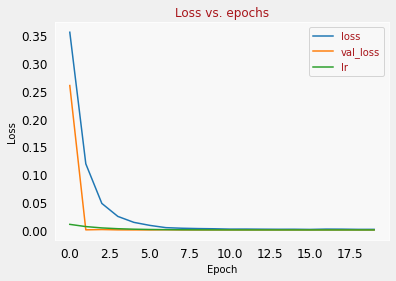

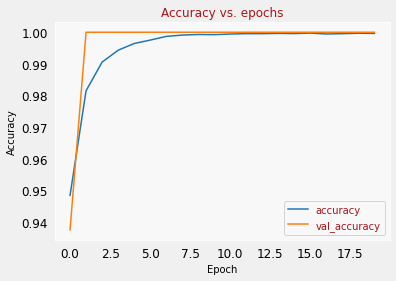

313/313 [==============================] - 4s 8ms/step - loss: 0.0278 - accuracy: 0.9943


[0.027803808450698853, 0.9943000078201294]

time: 4.43 s (started: 2022-01-23 01:30:29 +00:00)


In [ ]:
plot_history(history)
mpcnndnn.evaluate(test_X_images, test_Y_labels)

 the summary results for the fully parallel models

In [ ]:
x_input = test_X_images
y_input = test_targets

models_to_use = [mpdnn, mpcnn, mpcnndnn]
model_predictions = [ model.predict(test_X_images) for model in models_to_use]

test_Y_labels_as_numbers = np.apply_along_axis(np.argmax, 1, test_Y_labels)
scores_pdnn20_pcnn20_pdcnn20 = [ pr_rc_f1_acc_from_supplied(np.apply_along_axis(np.argmax, 1, y_pred), test_Y_labels_as_numbers) for y_pred in model_predictions ]

# tf.one_hot(,10, on_value=1.0, off_value = 0.0, axis=-1)

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/full_parallel_dnn20_cnn20_cnn10dnn10_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", 
        np.array(scores_pdnn20_pcnn20_pdcnn20), 
        allow_pickle=True, 
        fix_imports=True)


time: 5.62 s (started: 2022-01-23 02:34:01 +00:00)


In [ ]:
parallel_df = pd.DataFrame(np.array(scores_pdnn20_pcnn20_pdcnn20), columns = ['Pr','RC','F1','Acc'])
parallel_df['Type'] = [ 'DNN20' , 'CNN20', 'CNN10DNN10' ]
parallel_df.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/full_parallel_dnn20_cnn20_cnn10dnn10_summary_{datetime.datetime.now():%Y%m%d%H%M%S}.csv", index=False)

time: 11.4 ms (started: 2022-01-23 02:38:00 +00:00)


In [ ]:
scores_pdnn20_pcnn20_pdcnn20

# Set up the models + features file lists for CNN/DNN splits for reuse MNIST

In [ ]:
acceptable_string_grabs = [ "CNN_MNIST_", "DNN_MNIST_"]
not_check_model_string = ["arallel","Collab_"]

model_dirs = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}" 
                for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/") 
                if os.path.isdir(dir_entry) and any(xs in dir_entry.name for xs in acceptable_string_grabs) ]

dnn_model_dirs = [ s for s in model_dirs if "DNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
cnn_model_dirs = [ s for s in model_dirs if "CNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 

model_features_files = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{file_entry.name}" 
                for file_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/") 
                if os.path.isfile(file_entry) and any(xs in file_entry.name for xs in acceptable_string_grabs) ]

dnn_features_files = [ s for s in model_features_files if "DNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
cnn_features_files = [ s for s in model_features_files if "CNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 

dnn_identifier = acceptable_string_grabs[1]

cnn_identifier = acceptable_string_grabs[0]

def avgfilter_ensemble_predictions(y_pred_ms, xtest):
  y_preds_ens_prb = np.apply_along_axis(np.mean, 0, y_pred_ms)
  y_preds_ens_idx = np.apply_along_axis(np.argmax, 1, y_preds_ens_prb) 
  # y_preds_ens_idx = y_preds_ens_idx + 1
  return y_preds_ens_idx  




time: 155 ms (started: 2022-01-25 11:40:28 +00:00)


# Set up data for ensemble plot collection

In [ ]:
# set up the data
ensemble_test_results = None

time: 754 µs (started: 2022-01-24 16:10:50 +00:00)


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!
time: 3.29 ms (started: 2022-01-24 16:10:50 +00:00)


# Data for plot of #DNN in ensemble 

In [ ]:
dnn_loaded_models = dict(zip(dnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in dnn_model_dirs]))


time: 20.7 s (started: 2022-01-24 16:10:55 +00:00)


In [ ]:
# from numba import jit, prange
# @jit(nopython=True, parallel=True)
# def parallel_sum(A):
#     sum = 0.0
#     for i in prange(A.shape[0]):
#         sum += A[i]
#     return sum

In [ ]:
def avgfilter_ensemble_predictions(y_pred_ms, xtest):
  y_preds_ens_prb = np.apply_along_axis(np.mean, 0, y_pred_ms)
  y_preds_ens_idx = np.apply_along_axis(np.argmax, 1, y_preds_ens_prb) 
  # y_preds_ens_idx = y_preds_ens_idx + 1
  return y_preds_ens_idx  


time: 2.03 ms (started: 2022-01-24 16:11:15 +00:00)


In [ ]:
x_input = test_X_images
test_Y_labels_as_numbers = np.apply_along_axis(np.argmax, 1, test_Y_labels)
y_input = test_Y_labels_as_numbers

num_of_repeats = 4
num_of_models = [2,3,4,6,7,8,9,11,12,13,14,16,19,22,25,30,35,40]  

# model_predictions = [ model.predict(test_X_images) for model in models_to_use]
# test_Y_labels_as_numbers = np.apply_along_axis(np.argmax, 1, test_Y_labels)
# scores_pdnn20_pcnn20_pdcnn20 = [ pr_rc_f1_acc_from_supplied(np.apply_along_axis(np.argmax, 1, y_pred), test_Y_labels_as_numbers) for y_pred in model_predictions ]
# [ pr_rc_f1_acc_from_supplied(np.apply_along_axis(np.argmax, 1, y_pred), test_Y_labels_as_numbers) for y_pred in model_predictions ]

idxCount = 0 if ensemble_test_results is None else len(ensemble_test_results.index)
for mc in num_of_models:
  for repc in range(num_of_repeats):
    selected_model_names = sorted(random.sample(dnn_model_dirs, min(len(dnn_model_dirs),mc)))
    dnn_models_to_use = [ dnn_loaded_models[mn] for mn in selected_model_names ]
    dnn_model_predictions = [ model.predict(x_input) for model in dnn_models_to_use ]
    y_ens_preds = avgfilter_ensemble_predictions(dnn_model_predictions, x_input)
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_ens_preds,y_input)
    print (mc, repc, pr, rc, f1, acc)
    if ensemble_test_results is None:
      ensemble_test_results = pd.DataFrame({"Type": "DNN", 
                                            "Data" : "Test",
                                            "NumOfModels": len(selected_model_names), 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc # ,
                                            # "ModelNames": "XOX".join([ "_".join(zz.split("DNN_A_")[1].split("_")[:2]) for zz in selected_model_names])
                                            }, index = [idxCount])
    else:
      ensemble_test_results = pd.concat([ensemble_test_results,
                                         pd.DataFrame({"Type": "DNN", 
                                            "Data" : "Test",
                                            "NumOfModels": len(selected_model_names), 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc # ,
                                            # "ModelNames": "XOX".join([ "_".join(zz.split("DNN_A_")[1].split("_")[:2]) for zz in selected_model_names])
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1
    del dnn_models_to_use
    del dnn_model_predictions
    del y_ens_preds




2 0 0.9839113811823623 0.9839 0.9838982567263563 0.9839
2 1 0.9835157325804105 0.9835 0.9834969480232066 0.9835
2 2 0.9846113980596678 0.9846 0.9846015316147808 0.9846
2 3 0.9838347269090766 0.9838 0.9838046732848559 0.9838
3 0 0.9840230859634532 0.984 0.9840025662538315 0.984
3 1 0.9849119667016217 0.9849 0.984900366933319 0.9849
3 2 0.9848122438010152 0.9848 0.9848018083389297 0.9848
3 3 0.9854126699954977 0.9854 0.9854013899454499 0.9854
4 0 0.9852118204405702 0.9852 0.9852008037262676 0.9852
4 1 0.9856086113259924 0.9856 0.9856001633951675 0.9856
4 2 0.9845102211937284 0.9845 0.9845019592854621 0.9845
4 3 0.9846096951931218 0.9846 0.984598668496119 0.9846
6 0 0.9852090628921513 0.9852 0.9851987994003731 0.9852
6 1 0.9854054131838231 0.9854 0.9853992164097249 0.9854
6 2 0.9855070999637011 0.9855 0.9854997415714084 0.9855
6 3 0.9856068939716676 0.9856 0.9855994950346875 0.9856
7 0 0.9850096040807894 0.985 0.9850018739414347 0.985
7 1 0.9854159488080181 0.9854 0.9854024330514676 0.985

In [ ]:
ensemble_test_results.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/dnn_ensemble_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")

time: 11.3 ms (started: 2022-01-24 16:19:44 +00:00)


# Data for plot of #CNN in ensemble 

In [ ]:

# preload all the models
# resnet_loaded_models = dict(zip(resnets_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in resnets_model_dirs]))
# dnn_loaded_models = dict(zip(dnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in dnn_model_dirs]))
cnn_loaded_models = dict(zip(cnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in cnn_model_dirs]))
# wideresnet_loaded_models = dict(zip(wideresnets_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in wideresnets_model_dirs]))


time: 39.6 s (started: 2022-01-23 03:23:06 +00:00)


In [ ]:
# for CNN we try to memoize the predictions... ?
# cnn_model_predictions = [ cnn_loaded_models[mn].predict(x_input) for mn in list(cnn_loaded_models.keys()) ]

In [ ]:
# from numba import jit, prange
# @jit(nopython=True, parallel=True)
# def parallel_sum(A):
#     sum = 0.0
#     for i in prange(A.shape[0]):
#         sum += A[i]
#     return sum

In [ ]:
# num_of_models = [16,20]

x_input = test_X_images
test_Y_labels_as_numbers = np.apply_along_axis(np.argmax, 1, test_Y_labels)
y_input = test_Y_labels_as_numbers

num_of_repeats = 4
num_of_models = [2,3,4,6,7,8,9,11,12,13,14,16,19,22,25,30,35,40]  

idxCount = 0 if ensemble_test_results is None else len(ensemble_test_results.index)
for mc in num_of_models:
  for repc in range(num_of_repeats):
    selected_model_names = sorted(random.sample(cnn_model_dirs, min(len(cnn_model_dirs),mc)))
    cnn_models_to_use = [ cnn_loaded_models[mn] for mn in selected_model_names ]
    cnn_model_predictions = [ model.predict(x_input) for model in cnn_models_to_use ]
    y_ens_preds = avgfilter_ensemble_predictions(cnn_model_predictions, x_input)
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_ens_preds,y_input)
    print (mc, repc, pr, rc, f1, acc)
    if ensemble_test_results is None:
      ensemble_test_results = pd.DataFrame({"Type": "CNN", 
                                            "Data" : "Test",
                                            "NumOfModels": len(selected_model_names), 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc #,
                                            # "ModelNames": "XOX".join([ "_".join(zz.split("CNN_A_")[1].split("_")[:2]) for zz in selected_model_names])
                                            }, index = [idxCount])
    else:
      ensemble_test_results = pd.concat([ensemble_test_results,
                                         pd.DataFrame({"Type": "CNN", 
                                            "Data" : "Test",
                                            "NumOfModels": len(selected_model_names), 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc#,
                                            # "ModelNames": "XOX".join([ "_".join(zz.split("CNN_A_")[1].split("_")[:2]) for zz in selected_model_names])
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1
    del cnn_models_to_use
    del cnn_model_predictions
    del y_ens_preds




In [ ]:
ensemble_test_results.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_ensemble_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")


time: 9.28 ms (started: 2022-01-23 03:45:15 +00:00)


# Data for Contour Plot on Mixed CNN/DNN ensemble

In [ ]:
# dnn_loaded_models = dict(zip(dnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in dnn_model_dirs]))
cnn_loaded_models = dict(zip(cnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in cnn_model_dirs]))


time: 4min 17s (started: 2022-01-24 16:19:45 +00:00)


In [ ]:
x_input = test_X_images
test_Y_labels_as_numbers = np.apply_along_axis(np.argmax, 1, test_Y_labels)
y_input = test_Y_labels_as_numbers

num_of_repeats = 4
num_of_models = [2,3,4,6,7,8,9,11,12,13,14,16,19,22,25,30,35,40]  


time: 46.9 ms (started: 2022-01-24 16:24:03 +00:00)


In [ ]:
# for WideResNet we try to memoize the predictions... ?
dnn_model_predictions = [ dnn_loaded_models[mn].predict(x_input) for mn in dnn_model_dirs ]


time: 30.2 s (started: 2022-01-24 16:24:03 +00:00)


In [ ]:
cnn_model_predictions = [ cnn_loaded_models[mn].predict(x_input) for mn in list(cnn_loaded_models.keys()) ]

time: 31.5 s (started: 2022-01-24 16:24:33 +00:00)


In [ ]:
# wideresnets_model_dirs

In [ ]:
# set up the combinations we are going to try
# len(wideresnets_features_files)
cnn_dnn_ensemble_contour_data = None

time: 1.04 ms (started: 2022-01-24 16:25:04 +00:00)


In [ ]:
idxCount = 0 if cnn_dnn_ensemble_contour_data is None else len(cnn_dnn_ensemble_contour_data.index)
for mc in num_of_models:
  for repc in range(num_of_repeats):
    for num_of_dnn in range(mc+1):
      num_of_cnn = mc - num_of_dnn

      ensemble_model_predictions_here = []
      if num_of_cnn > 0:
        ensemble_model_predictions_here.extend(random.sample(cnn_model_predictions, min(num_of_cnn,len(cnn_model_predictions)) ))
      if num_of_dnn > 0:
        ensemble_model_predictions_here.extend(random.sample(dnn_model_predictions, min(num_of_dnn,len(dnn_model_predictions)) ))

      y_ens_preds = avgfilter_ensemble_predictions(ensemble_model_predictions_here, x_input)
      pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_ens_preds,y_input)
      print (mc, num_of_cnn, repc, pr, rc, f1, acc)
      if cnn_dnn_ensemble_contour_data is None:
        cnn_dnn_ensemble_contour_data = pd.DataFrame({"TypeA": "CNN", 
                                                             "TypeB": "DNN", 
                                                              "Data" : "Test",
                                                             "Layer" : "Ensemble",
                                                    "NumOfA": num_of_cnn, 
                                                    "NumOfB": num_of_dnn, 
                                                    "RepC": repc, 
                                                    "Pr": pr,
                                                    "Rc": rc,
                                                    "F1": f1,
                                                    "Acc": acc
                                              }, index = [idxCount])
      else:
        cnn_dnn_ensemble_contour_data = pd.concat([cnn_dnn_ensemble_contour_data,
                                                          pd.DataFrame({"TypeA": "CNN", 
                                                                        "TypeB": "DNN", 
                                                                        "Data" : "Test",
                                                                        "Layer" : "Ensemble",
                                                                        "NumOfA": num_of_cnn, 
                                                                        "NumOfB": num_of_dnn, 
                                                                        "RepC": repc, 
                                                                        "Pr": pr,
                                                                        "Rc": rc,
                                                                        "F1": f1,
                                                                        "Acc": acc
                                                                        }, index = [idxCount])])
      idxCount = idxCount + 1
      # del resnet_models_to_use
      del ensemble_model_predictions_here
      del y_ens_preds



In [ ]:
cnn_dnn_ensemble_contour_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_dnn_ensemble_contour_data_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")



time: 15.1 ms (started: 2022-01-24 16:51:24 +00:00)


# Functions for collaborative learning (no GP) based on last dense and softmax layer features for DNN/CNN inputs

A sequential model for DNN on collaborative features

In [ ]:
def model_combination_of_features(model_name, input_shape,num_classes=10):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        BatchNormalization(),
        Dense(256, kernel_initializer='RandomNormal', bias_initializer='zeros'),
        LeakyReLU(),
        Dropout(0.6),
        Dense(128, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-3)),
        LeakyReLU(),
        Dropout(0.6),
        Dense(32, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-2)),
        LeakyReLU(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name=model_name)
    return model


def model_combination_of_features_with_flatten(model_name, input_shape,num_classes=10):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        Flatten(),
        BatchNormalization(),
        Dense(256, kernel_initializer='RandomNormal', bias_initializer='zeros'),
        LeakyReLU(),
        Dropout(0.6),
        Dense(128, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-3)),
        LeakyReLU(),
        Dropout(0.6),
        Dense(32, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-2)),
        LeakyReLU(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name=model_name)
    return model    


# X_trains_out.append(np.array(features_model.predict(X_train_combined), dtype='float64'))
# X_train_new = np.concatenate(tuple(X_trains_out), axis=1)


time: 17.3 ms (started: 2022-01-25 11:40:22 +00:00)


In [ ]:
def get_features_from_multiple_models(feature_files, axis_to_concat = 1):
 
  validation_features_to_load = [ff for ff in feature_files if "Validation" in ff and "_X" in ff ]
  np_x_validation_collab = np.array([np.load(ff) for ff in validation_features_to_load])
  np_x_validation_collab = np.concatenate(np_x_validation_collab, axis=axis_to_concat)

  train_features_to_load = [ff.replace("Validation", "Train") for ff in validation_features_to_load]
  np_x_train_collab = np.array([np.load(ff) for ff in train_features_to_load])
  np_x_train_collab = np.concatenate(np_x_train_collab, axis=axis_to_concat)

  test_features_to_load = [ff.replace("Validation", "Test") for ff in validation_features_to_load]
  np_x_test_collab = np.array([np.load(ff) for ff in test_features_to_load])
  np_x_test_collab = np.concatenate(np_x_test_collab, axis=axis_to_concat)

  return np_x_validation_collab, np_x_train_collab, np_x_test_collab

time: 8.72 ms (started: 2022-01-25 11:40:22 +00:00)


In [ ]:
def get_features_for_layer(feature_files, layer_name, num_of_models, axis_to_concat = 1):
 
  feature_files_used = [ff for ff in feature_files if "Validation" in ff and "_X" in ff and f"{layer_name}_" in ff ]
  validation_features_to_load = sorted(random.sample(feature_files_used, min(num_of_models,len(feature_files_used)) ))
  np_x_validation_collab = np.array([np.load(ff) for ff in validation_features_to_load])
  np_x_validation_collab = np.concatenate(np_x_validation_collab, axis=axis_to_concat)

  train_features_to_load = [ff.replace("Validation", "Train") for ff in validation_features_to_load]
  np_x_train_collab = np.array([np.load(ff) for ff in train_features_to_load])
  np_x_train_collab = np.concatenate(np_x_train_collab, axis=axis_to_concat)

  test_features_to_load = [ff.replace("Validation", "Test") for ff in validation_features_to_load]
  np_x_test_collab = np.array([np.load(ff) for ff in test_features_to_load])
  np_x_test_collab = np.concatenate(np_x_test_collab, axis=axis_to_concat)

  return np_x_validation_collab, np_x_train_collab, np_x_test_collab



time: 11.3 ms (started: 2022-01-25 11:40:22 +00:00)


# Collaborative learning on DNN models based on last dense and softmax layer features

Do a collaborative layer on 20 DNN on features of penultimate layer

In [ ]:
# validation_Y_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0]], dtype=int32)

time: 3.65 ms (started: 2022-01-23 04:26:05 +00:00)


In [ ]:
# set up the data for the DNN collaborative

# dnn_features_files
# cnn_features_files

import random
import datetime

num_of_models = 20
layer_name_penultimate_dnn = "LD1"

np_x_validation_collab_dnn_penultimate, np_x_train_collab_dnn_penultimate, np_x_test_collab_dnn_penultimate = get_features_for_layer(dnn_features_files, layer_name_penultimate_dnn, num_of_models)
# np_x_validation_collab_dnn_penultimate, np_x_train_collab_dnn_penultimate, np_x_test_collab_dnn_penultimate = get_features_for_layer_fixed_set(dnn_features_files, layer_name_penultimate_dnn, num_of_models)

start_time = timeit.default_timer()
fcd1, fcdh1 = compile_and_fit_model_basic( model_combination_of_features,  
                    f"Collab_{layer_name_penultimate_dnn}_DNN{num_of_models}_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    np_x_train_collab_dnn_penultimate[0,:].shape, 
                    np_x_train_collab_dnn_penultimate, 
                    train_Y_labels,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_categorical_accuracy',
                    log_history = True,
                    verbose_level=1,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(np_x_validation_collab_dnn_penultimate, validation_Y_labels))
                    # validation_data=(test_data_grey, test_targets))
print(timeit.default_timer()-start_time)



In [ ]:
fcd1.evaluate(np_x_test_collab_dnn_penultimate, test_Y_labels)

313/313 [==============================] - 1s 2ms/step - loss: 1.0235 - categorical_accuracy: 0.9849


[1.0235345363616943, 0.9848999977111816]

time: 1.08 s (started: 2022-01-24 16:59:24 +00:00)


In [ ]:
# np_x_train_collab_dnn_sftmx[:,:10]
np_x_test_collab_dnn_penultimate.shape

(10000, 8000)

time: 2.85 ms (started: 2022-01-24 17:00:09 +00:00)


Do a collaborative layer on 20 DNN on features of softmax layer

In [ ]:
# set up the data for the DNN collaborative

import random
num_of_models = 20
layer_name_sfmx_dnn = "SFTMX"
np_x_validation_collab_dnn_sftmx, np_x_train_collab_dnn_sftmx, np_x_test_collab_dnn_sftmx = get_features_for_layer(dnn_features_files, layer_name_sfmx_dnn, num_of_models)

start_time = timeit.default_timer()
fcd2, fcdh2 = compile_and_fit_model_basic( model_combination_of_features,  
                    f"Collab_{layer_name_sfmx_dnn}_DNN{num_of_models}_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    np_x_train_collab_dnn_sftmx[0,:].shape, 
                    np_x_train_collab_dnn_sftmx, 
                    train_Y_labels,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_categorical_accuracy',
                    log_history = True,
                    verbose_level=1,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(np_x_validation_collab_dnn_sftmx, validation_Y_labels))
                    # validation_data=(test_data_grey, test_targets))
print(timeit.default_timer()-start_time)



In [ ]:
print(np_x_validation_collab_dnn_sftmx[0,:10].sum())

fcd2.evaluate(np_x_test_collab_dnn_sftmx, test_Y_labels)

1.000000014902688
313/313 [==============================] - 1s 2ms/step - loss: 0.3008 - categorical_accuracy: 0.9853


[0.3007817268371582, 0.9853000044822693]

time: 662 ms (started: 2022-01-24 17:03:53 +00:00)


# Data for Plot on Collaborative DNN softmax layers

In [ ]:
collaborativeFullyC_softmax_data = None

time: 1.02 ms (started: 2022-01-24 17:20:34 +00:00)


In [ ]:
# dnn_features_files_here = [ f for f in dnn_features_files if layer_name_sfmx_dnn in f]
# dnn_features_files_here


In [ ]:
# set up the data for the DNN collaborative

import random
import datetime

num_of_repeats = 1
num_of_models = [2,3,4,5,6,8,10,12,14,16,18,20,25,30,35,40,45,50] 
layer_name_sfmx_dnn = "SFTMX"

idxCount = 0 if collaborativeFullyC_softmax_data is None else len(collaborativeFullyC_softmax_data.index)
for repc in range(num_of_repeats):
  for mc in num_of_models:
    model_name = f"Collab_{layer_name_sfmx_dnn}_DNN{mc}_A_{datetime.datetime.now():%Y%m%d%H%M%S}"
    np_x_validation_collab_dnn_sftmx, np_x_train_collab_dnn_sftmx, np_x_test_collab_dnn_sftmx = get_features_for_layer(dnn_features_files, layer_name_sfmx_dnn, mc)
    model_here, history_here = compile_and_fit_model_basic( model_combination_of_features,  
                    model_name, 
                    np_x_train_collab_dnn_sftmx[0,:].shape, 
                    np_x_train_collab_dnn_sftmx, 
                    train_Y_labels,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_categorical_accuracy',
                    log_history = True,
                    verbose_level=0,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(np_x_validation_collab_dnn_sftmx, validation_Y_labels))

    del np_x_validation_collab_dnn_sftmx
    del np_x_train_collab_dnn_sftmx
    y_pred_model = model_here.predict(np_x_test_collab_dnn_sftmx)
    del np_x_test_collab_dnn_sftmx
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model) 
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred,test_Y_labels_as_numbers)
    print (mc, repc, pr, rc, f1, acc)
    del model_here
    del history_here
    if collaborativeFullyC_softmax_data is None:
      collaborativeFullyC_softmax_data = pd.DataFrame({"Type": "DNN", 
                                            "Data" : "Test",
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc
                                            }, index = [idxCount])
    else:
      collaborativeFullyC_softmax_data = pd.concat([collaborativeFullyC_softmax_data,
                                         pd.DataFrame({"Type": "DNN", 
                                            "Data" : "Test",
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1





In [ ]:
collaborativeFullyC_softmax_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/dnn_collab_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")



time: 6.85 ms (started: 2022-01-24 17:47:10 +00:00)


# Data for Plot on Collaborative CNN softmax layers

In [ ]:
# carry this over from DNN if possible (so keep commented out)
## collaborativeFullyC_softmax_data = None

In [ ]:
# set up the data for the CNN collaborative

import random
import datetime

num_of_repeats = 1
num_of_models = [2,3,4,5,6,8,10,12,14,16,18,20,22,25,30,35,40,50]  # [2,3,4,5,6,8,10,12,14,16,18,20]
layer_name_sfmx_cnn = "SFTMX"

# layer_name_sftmx_cnn = "SFTMX1"
# layer_name_sftmx_wideresnets = "CLASSIFIER_D1"

idxCount = 0 if collaborativeFullyC_softmax_data is None else len(collaborativeFullyC_softmax_data.index)
for repc in range(num_of_repeats):
  for mc in num_of_models:
    model_name = f"Collab_{layer_name_sfmx_cnn}_CNN{mc}_A_{datetime.datetime.now():%Y%m%d%H%M%S}"
    np_x_validation_collab_cnn_sftmx, np_x_train_collab_cnn_sftmx, np_x_test_collab_cnn_sftmx = get_features_for_layer(cnn_features_files, layer_name_sfmx_cnn, mc)

    model_here, history_here = compile_and_fit_model_basic( model_combination_of_features,  
                    model_name, 
                    np_x_train_collab_cnn_sftmx[0,:].shape, 
                    np_x_train_collab_cnn_sftmx, 
                    train_Y_labels,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_categorical_accuracy',
                    log_history = True,
                    verbose_level=0,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(np_x_validation_collab_cnn_sftmx, validation_Y_labels))
    del np_x_validation_collab_cnn_sftmx
    del np_x_train_collab_cnn_sftmx
    y_pred_model = model_here.predict(np_x_test_collab_cnn_sftmx)
    del np_x_test_collab_cnn_sftmx
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model) 
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred,test_Y_labels_as_numbers)
    print (mc, repc, pr, rc, f1, acc)
    del model_here
    del history_here
    if collaborativeFullyC_softmax_data is None:
      collaborativeFullyC_softmax_data = pd.DataFrame({"Type": "CNN", 
                                            "Data" : "Test",
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            }, index = [idxCount])
    else:
      collaborativeFullyC_softmax_data = pd.concat([collaborativeFullyC_softmax_data,
                                         pd.DataFrame({"Type": "CNN", 
                                            "Data" : "Test",
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1


In [ ]:
collaborativeFullyC_softmax_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_collab_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")


time: 8.1 ms (started: 2022-01-24 18:19:44 +00:00)


# Data for Contour Plot on Collaborative CNN/DNN softmax layers

In [ ]:
import random
import re

def get_base_patterns_for_validation(features_files, layer_name = "SFTMX", model_type = "CNN"):
  base_patterns_for_validations = []
  for ff in [ s for s in features_files if "Validation" in s]:
    validation_search = re.search(f'^.*({model_type}.*_ID.*features_{layer_name}_Validation)[0-9]+.*$', ff, re.IGNORECASE)
    if validation_search:
        base_patterns_for_validations.append(validation_search.group(1))

  base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))
  return base_patterns_for_validations



In [ ]:
# set up the combinations we are going to try
# len(wideresnets_features_files)
cnn_dnn_contour_data = None

In [ ]:
# set up the data for the DNN+CNN collaborative on softmax layer
import random
layer_name_sftmx_cnn = "SFTMX"
layer_name_sftmx_dnn = "SFTMX"
total_num_components = [2,4,6,8,10,12,14,16,18,20,24,28,32,36,38,40]
num_of_repeats = 2

idxCount = 0 if cnn_dnn_contour_data is None else len(cnn_dnn_contour_data.index)

for repc in range(num_of_repeats):
  for component_count in total_num_components:
    for num_of_models_cnn in range(component_count+1):
      num_of_models_dnn = component_count - num_of_models_cnn

      np_x_validation_collab_cnn, np_x_train_collab_cnn, np_x_test_collab_cnn = (None,None,None)
      np_x_validation_collab_dnn, np_x_train_collab_dnn, np_x_test_collab_dnn = (None,None,None)
      np_x_validation_collab_cdnn, np_x_train_collab_cdnn, np_x_test_collab_cdnn = (None,None,None)

      if num_of_models_cnn > 0:
        np_x_validation_collab_cnn, np_x_train_collab_cnn, np_x_test_collab_cnn = get_features_for_layer(cnn_features_files,layer_name_sftmx_cnn,num_of_models_cnn)

      if num_of_models_dnn > 0:
        np_x_validation_collab_dnn, np_x_train_collab_dnn, np_x_test_collab_dnn = get_features_for_layer(dnn_features_files,layer_name_sftmx_dnn,num_of_models_dnn)
      
      if num_of_models_cnn > 0 and num_of_models_dnn > 0:        
        np_x_train_collab_cdnn = np.concatenate([np_x_train_collab_cnn,np_x_train_collab_dnn], axis=1)
        np_x_validation_collab_cdnn = np.concatenate([np_x_validation_collab_cnn,np_x_validation_collab_dnn], axis=1)
        np_x_test_collab_cdnn = np.concatenate([np_x_test_collab_cnn,np_x_test_collab_dnn], axis=1)
      else: 
        if num_of_models_cnn == 0:
          np_x_train_collab_cdnn = np_x_train_collab_dnn
          np_x_validation_collab_cdnn = np_x_validation_collab_dnn
          np_x_test_collab_cdnn = np_x_test_collab_dnn
        if num_of_models_dnn == 0:
          np_x_train_collab_cdnn = np_x_train_collab_cnn
          np_x_validation_collab_cdnn = np_x_validation_collab_cnn
          np_x_test_collab_cdnn = np_x_test_collab_cnn
      
      layer_name = f"CNN{layer_name_sftmx_cnn}_DNN{layer_name_sftmx_dnn}_CNN{str(num_of_models_cnn)}-DNN{str(num_of_models_dnn)}"
      model_name = f"Collab_{layer_name}_CNNDNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}"
      
      model_here, history_here = compile_and_fit_model_basic( model_combination_of_features_with_flatten,  
                      model_name, 
                      np_x_train_collab_cdnn[0,:].shape, 
                      np_x_train_collab_cdnn, 
                      train_Y_labels,
                      save_max_epoch=False,
                      save_final=True,
                      patience_count = 35,
                      early_stopping_obs = 'val_categorical_accuracy',
                      log_history = True,
                      verbose_level=0,                             
                      batch_size=512, 
                      epochs=250, 
                      class_weight=None, 
                      validation_data=(np_x_validation_collab_cdnn, validation_Y_labels))

      del np_x_train_collab_cdnn
      del np_x_validation_collab_cdnn
      del np_x_validation_collab_cnn
      del np_x_train_collab_cnn
      del np_x_validation_collab_dnn
      del np_x_train_collab_dnn
      
      y_pred_model = model_here.predict(np_x_test_collab_cdnn)
      del np_x_test_collab_cnn
      del np_x_test_collab_dnn
      del np_x_test_collab_cdnn

      y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model) 
      pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred,test_Y_labels_as_numbers)
      print (num_of_models_cnn, repc, pr, rc, f1, acc)
      del model_here
      del history_here
      if cnn_dnn_contour_data is None:
        cnn_dnn_contour_data = pd.DataFrame({"TypeA": "CNN", 
                                                    "TypeB": "DNN", 
                                                    "Data" : "Test",
                                                    "NumOfA": num_of_models_cnn, 
                                                    "NumOfB": num_of_models_dnn, 
                                                    "RepC": repc, 
                                                    "Pr": pr,
                                                    "Rc": rc,
                                                    "F1": f1,
                                                    "Acc": acc,
                                                    }, index = [idxCount])
      else:
        cnn_dnn_contour_data = pd.concat([cnn_dnn_contour_data,
                                          pd.DataFrame({"TypeA": "CNN", 
                                              "TypeB": "DNN", 
                                              "Data" : "Test",
                                              "NumOfA": num_of_models_cnn, 
                                              "NumOfB": num_of_models_dnn, 
                                              "RepC": repc, 
                                              "Pr": pr,
                                              "Rc": rc,
                                              "F1": f1,
                                              "Acc": acc
                                              }, index = [idxCount])
                                          ])
      idxCount = idxCount + 1
    


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/mnist/model_finals/Collab_CNNSFTMX_DNNSFTMX_CNN0-DNN2_CNNDNN_A_20220125115419_saved_model_after_fit/assets
0 0 0.9844155251783906 0.9844 0.9844027981127869 0.9844
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/mnist/model_finals/Collab_CNNSFTMX_DNNSFTMX_CNN1-DNN1_CNNDNN_A_20220125115438_saved_model_after_fit/assets
1 0 0.992800165701776 0.9928 0.9927973312138383 0.9928
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/mnist/model_finals/Collab_CNNSFTMX_DNNSFTMX_CNN2-DNN0_CNNDNN_A_20220125115456_saved_model_after_fit/assets
2 0 0.9948037935721014 0.9948 0.9948001367847257 0.9948
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/mnist/model_finals/Collab_CNNSFTMX_DNNSFTMX_CNN0-DNN4_CNNDNN_A_20220125115518_saved_model_after_fit/assets
0 0 0.9842225155074279 0.9842 0.984201569222062 0.9842
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/

In [ ]:
cnn_dnn_contour_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_dnn_collab_contour_data_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")


# Data for Plot on Collaborative DNN last dense layers

In [ ]:
collaborativeFullyC_lastdense_data = None


In [ ]:
# dnn_features_files_here = [ f for f in dnn_features_files if layer_name_sfmx_dnn in f]
# dnn_features_files_here


In [ ]:
# set up the data for the DNN collaborative

import random
import datetime

num_of_repeats = 1
num_of_models = [2,3,4,5,6,8,10,12,14,16,18,20]

layer_name_penultimate_dnn = "LD1"

idxCount = 0 if collaborativeFullyC_lastdense_data is None else len(collaborativeFullyC_lastdense_data.index)
for repc in range(num_of_repeats):
  for mc in num_of_models:
    model_name = f"Collab_{layer_name_penultimate_dnn}_DNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}"
    
    np_x_validation_collab_dnn_penultimate, np_x_train_collab_dnn_penultimate, np_x_test_collab_dnn_penultimate = get_features_for_layer(dnn_features_files, layer_name_penultimate_dnn, mc)
    model_here, history_here = compile_and_fit_model_basic( model_combination_of_features,  
                        model_name, 
                        np_x_train_collab_dnn_penultimate[0,:].shape, 
                        np_x_train_collab_dnn_penultimate, 
                        train_Y_labels,
                        save_max_epoch = False,
                        save_final = True,
                        patience_count = 35,
                        early_stopping_obs = 'val_categorical_accuracy',
                        log_history = True,
                        verbose_level=0,                             
                        batch_size=512, 
                        epochs=250, 
                        class_weight=None, 
                        validation_data=(np_x_validation_collab_dnn_penultimate, validation_Y_labels))

    del np_x_validation_collab_dnn_penultimate
    del np_x_train_collab_dnn_penultimate
    y_pred_model = model_here.predict(np_x_test_collab_dnn_penultimate)
    del np_x_test_collab_dnn_penultimate
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model) 
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred,test_Y_labels_as_numbers)
    print (mc, repc, pr, rc, f1, acc)
    del model_here
    del history_here
    if collaborativeFullyC_lastdense_data is None:
      collaborativeFullyC_lastdense_data = pd.DataFrame({"Type": "DNN", 
                                            "Data" : "Test",
                                            "Layer" : layer_name_penultimate_dnn,
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            }, index = [idxCount])
    else:
      collaborativeFullyC_lastdense_data = pd.concat([collaborativeFullyC_lastdense_data,
                                         pd.DataFrame({"Type": "DNN", 
                                            "Data" : "Test",
                                            "Layer" : layer_name_penultimate_dnn,
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1





INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/mnist/model_finals/Collab_LD1_DNN_A_20220125151059_saved_model_after_fit/assets
2 0 0.9826531387129526 0.9826 0.9826065850670486 0.9826
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/mnist/model_finals/Collab_LD1_DNN_A_20220125151220_saved_model_after_fit/assets
3 0 0.9834226774763467 0.9834 0.98340283968719 0.9834
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/mnist/model_finals/Collab_LD1_DNN_A_20220125151349_saved_model_after_fit/assets
4 0 0.9831919994107242 0.9831 0.9831069622825643 0.9831
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/mnist/model_finals/Collab_LD1_DNN_A_20220125151533_saved_model_after_fit/assets
5 0 0.9849680729526481 0.9849 0.9849104263714499 0.9849
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/mnist/model_finals/Collab_LD1_DNN_A_20220125151646_saved_model_after_fit/assets
6 0 0.983043782280991 0.983 

In [ ]:
collaborativeFullyC_lastdense_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/dnn_collab_lastdense_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")



time: 6.96 ms (started: 2022-01-25 15:31:07 +00:00)


# Data for Plot on Collaborative CNN last dense layers

In [ ]:
# carry this over from DNN if possible (so keep commented out)
## collaborativeFullyC_lastdense_data = None

In [ ]:
# set up the data for the CNN collaborative

import random
import datetime

num_of_repeats = 2
num_of_models = [2,3,4,5,6,8,10,12,14,16,18,20, 22, 25,30]
# [2,3,4,5,6,8,10,12,14,16,18,20]

layer_name_penultimate_cnn = "LD1"

idxCount = 0 if collaborativeFullyC_lastdense_data is None else len(collaborativeFullyC_lastdense_data.index)
for repc in range(num_of_repeats):
  for mc in num_of_models:
    model_name = f"Collab_{layer_name_penultimate_cnn}_CNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}"
    np_x_validation_collab_cnn_penultimate, np_x_train_collab_cnn_penultimate, np_x_test_collab_cnn_penultimate = get_features_for_layer(cnn_features_files, layer_name_penultimate_cnn, mc)
    model_here, history_here = compile_and_fit_model_basic( model_combination_of_features,  
                        model_name, 
                        np_x_train_collab_cnn_penultimate[0,:].shape, 
                        np_x_train_collab_cnn_penultimate, 
                        train_Y_labels,
                        save_max_epoch = False,
                        save_final = True,
                        patience_count = 35,
                        early_stopping_obs = 'val_categorical_accuracy',
                        log_history = True,
                        verbose_level=0,                             
                        batch_size=512, 
                        epochs=250, 
                        class_weight=None, 
                        validation_data=(np_x_validation_collab_cnn_penultimate, validation_Y_labels))
    del np_x_validation_collab_cnn_penultimate
    del np_x_train_collab_cnn_penultimate
    y_pred_model = model_here.predict(np_x_test_collab_cnn_penultimate)
    del np_x_test_collab_cnn_penultimate
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model) 
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred,test_Y_labels_as_numbers)
    print (mc, repc, pr, rc, f1, acc)
    del model_here
    del history_here
    if collaborativeFullyC_lastdense_data is None:
      collaborativeFullyC_lastdense_data = pd.DataFrame({"Type": "CNN", 
                                            "Data" : "Test",
                                            "Layer" : layer_name_penultimate_cnn,
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            }, index = [idxCount])
    else:
      collaborativeFullyC_lastdense_data = pd.concat([collaborativeFullyC_lastdense_data,
                                         pd.DataFrame({"Type": "CNN", 
                                            "Data" : "Test",
                                            "Layer" : layer_name_penultimate_cnn,
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1





INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/mnist/model_finals/Collab_LD1_CNN_A_20220125160110_saved_model_after_fit/assets
2 0 0.9935116887016431 0.9935 0.9934991665110656 0.9935
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/mnist/model_finals/Collab_LD1_CNN_A_20220125160137_saved_model_after_fit/assets
3 0 0.9935145740079333 0.9935 0.9934994370312926 0.9935
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/mnist/model_finals/Collab_LD1_CNN_A_20220125160209_saved_model_after_fit/assets
4 0 0.9944036820782558 0.9944 0.994398733743002 0.9944
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/mnist/model_finals/Collab_LD1_CNN_A_20220125160255_saved_model_after_fit/assets
5 0 0.9928168647518627 0.9928 0.9928014329730717 0.9928
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/mnist/model_finals/Collab_LD1_CNN_A_20220125160328_saved_model_after_fit/assets
6 0 0.9940071216999048 0.99

In [ ]:
collaborativeFullyC_lastdense_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_collab_lastdense_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")


time: 8.43 ms (started: 2022-01-25 16:34:46 +00:00)


# MNIST base CNN seperate train/test

In [ ]:
import os
# Turn off TensorFlow warning messages in program output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

class Image_CNN(Model):
  def __init__(self):
    super().__init__()
    self.conv1 = Conv2D(32, 3, input_shape=(..., 3), strides=1, activation='relu')
    self.conv2 = Conv2D(32, 3, strides=1, activation='relu')
    self.conv3 = Conv2D(32, 5, strides=2, activation='relu')

    self.pool1 = MaxPool2D(pool_size=(2,2))
    self.batchnorm = BatchNormalization()
    self.dropout40 = Dropout(rate=0.4)

    self.flatten = Flatten()
    self.d128 = Dense(128, activation='relu')
    self.d10softmax = Dense(10, activation='softmax')

  def call(self, x, training=False):
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool1(x)
    x = self.conv3(x)
    x = self.batchnorm(x)
    if training:
        x = self.dropout40(x, training=training)

    x = self.flatten(x)
    x = self.d128(x)
    x = self.d10softmax(x)

    return x

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
import time
start_time = time.time()

# Load MNIST images and normalize pixel range to 0-1.
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension.
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

# Set up a data pipeline for feeding the training and testing data into the model.
shuff_size = int(0.25 * len(y_train))
batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(shuff_size).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# Instantiate our neural network model from the predefined class. Also define the loss function and optimizer.
model = Image_CNN()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

# Define the metrics for loss and accuracy.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Run and iterate model over epochs
EPOCHS = 10
for epoch in range(EPOCHS):

  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  # Train then test the model
  for images, labels in train_ds:
    train_step(images, labels)
  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  # Print results
  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch + 1,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        test_loss.result(),
                        test_accuracy.result() * 100))
print("time elapsed: {:.2f}s".format(time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 1, Loss: 0.23702245950698853, Accuracy: 93.03333282470703, Test Loss: 0.08366331458091736, Test Accuracy: 97.23999786376953
Epoch 2, Loss: 0.10238919407129288, Accuracy: 96.93499755859375, Test Loss: 0.03710401803255081, Test Accuracy: 98.72000122070312
Epoch 3, Loss: 0.0846385732293129, Accuracy: 97.44667053222656, Test Loss: 0.04444322735071182, Test Accuracy: 98.58000183105469
Epoch 4, Loss: 0.06874535977840424, Accuracy: 97.9816665649414, Test Loss: 0.03960805758833885, Test Accuracy: 98.72000122070312
Epoch 5, Loss: 0.05994188413023949, Accuracy: 98.15333557128906, Test Loss: 0.05870003253221512, Test Accuracy: 98.22000122070312
Epoch 6, Loss: 0.05666183680295944, Accuracy: 98.336669921875, Test Loss: 0.03189082816243172, Test Accuracy: 99.05999755859375
Epoch 7, Loss: 0.0530717708170414, Accuracy: 98.37333679199219, Test Loss: 0.02465825527906418, Test Accuracy: 99.2699966430664
Epoch 8, Loss: 0.049936581403017044, Accuracy: 98.50999450683594, Test Loss: 0.03248704224824905

# MNIST EnsCNN Fit (not working)

https://github.com/dslisleedh/EnsNet-tensorflow2

bibtex:
@article{Hirata2020EnsembleLI,
  title={Ensemble learning in CNN augmented with fully connected subnetworks},
  author={Daiki Hirata and Norikazu Takahashi},
  journal={ArXiv},
  year={2020},
  volume={abs/2003.08562}
}



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *

import tensorflow as tf

class Conv(tf.keras.layers.Layer):
    def __init__(self, filters,
                 padding = 'same',
                 strides = (1,1),
                 activation = 'relu',
                 dropout_rate = .25,
                 pool = False
                 ):
        super(Conv, self).__init__()
        self.filters = filters
        self.strides = strides
        self.padding = padding
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.pool = pool

        self.C = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters = self.filters,
                                   kernel_size = (3,3),
                                   padding = self.padding,
                                   strides = self.strides,
                                   activation = self.activation
                                   ),
            tf.keras.layers.BatchNormalization()
        ])
        if self.pool:
            self.C.add(tf.keras.layers.MaxPool2D(pool_size = (2,2),
                                                 strides = (2,2),
                                                 padding = 'same'
                                                 )
                       )
        self.C.add(tf.keras.layers.Dropout(self.dropout_rate))

    def call(self, inputs, **kwargs):
        return self.C(inputs)


class Dropconnectdense(tf.keras.layers.Layer):
    def __init__(self, units, prob):
        self.prob = prob
        self.units = units
        super(Dropconnectdense, self).__init__()

        self.dropout = tf.keras.layers.Dropout(self.prob)

    def build(self, input_shape):
        self.kernel = self.add_weight('kernel',
                                      shape=[int(input_shape[-1]),
                                             self.units],
                                      trainable=True)
        self.bias = self.add_weight('bias',
                                    shape=[self.units, ],
                                    trainable=True
                                    )

    def call(self, inputs, **kwargs):
        y = tf.matmul(inputs, self.dropout(self.kernel),) + self.dropout(self.bias)
        return tf.nn.relu(y)



class Cnn(tf.keras.layers.Layer):
    def __init__(self, dataset):
        super(Cnn, self).__init__()
        self.dataset = dataset

        self.Conv = tf.keras.Sequential([
            Conv(filters=64,
                 padding='valid',
                 dropout_rate=.25 if self.dataset == 'cifar10' else .35,
                 ),
            Conv(filters=128,
                 dropout_rate=.25 if self.dataset == 'cifar10' else .35
                 ),
            Conv(filters=256,
                 padding='valid',
                 pool=True,
                 dropout_rate=.25 if self.dataset == 'cifar10' else .35
                 ),
            Conv(filters=512,
                 padding='valid',
                 dropout_rate=.25 if self.dataset == 'cifar10' else .35
                 ),
            Conv(filters=1024,
                 dropout_rate=.25 if self.dataset == 'cifar10' else .35
                 ),
            Conv(filters=2048 if self.dataset == 'cifar10' else 2000,
                 padding='valid',
                 pool=True,
                 dropout_rate=.25 if self.dataset == 'cifar10' else .35
                 )
        ])
        if self.dataset == 'cifar10':
            self.Conv.add(Conv(filters=3000,
                               padding='valid'
                               )
                          )
            self.Conv.add(Conv(filters=3500,
                               padding='valid'
                               )
                          )
            self.Conv.add(Conv(filters=4000,
                               padding='valid'
                               )
                          )

    def call(self, inputs, **kwargs):
        y = self.Conv(inputs)
        return y


class Subnetwork(tf.keras.layers.Layer):
    def __init__(self, n_nodes, drop_rate, n_labels):
        super(Subnetwork, self).__init__()
        self.n_nodes = n_nodes
        self.drop_rate = drop_rate
        self.n_labels = n_labels

        self.classifier = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(self.n_nodes,
                                  activation='relu',
                                  ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(self.drop_rate),
            Dropconnectdense(units=self.n_nodes,
                             prob=self.drop_rate
                             ),
            tf.keras.layers.Dense(self.n_labels,
                                  activation='softmax'
                                  )
        ])

    def call(self, inputs, **kwargs):
        return self.classifier(inputs)

class Subnetworks(tf.keras.layers.Layer):
    def __init__(self, n_labels, dataset):
        super(Subnetworks, self).__init__()
        self.n_labels = n_labels
        self.dataset = dataset

        self.subnetworks = [Subnetwork(n_nodes=512,
                                       drop_rate=.3 if self.dataset == 'cifar10' else .5,
                                       n_labels=self.n_labels
                                       ) for _ in range(10)
                            ]

    def call(self, inputs, **kwargs):
        features = tf.split(inputs,
                     num_or_size_splits = 10,
                     axis = -1)
        y = [subnet(divition, **kwargs) for divition, subnet in zip(features, self.subnetworks)]
        return y


class Ensnet(tf.keras.models.Model):
    def __init__(self, n_labels, dataset = 'mnist'):
        super(Ensnet, self).__init__()
        self.n_labels = n_labels
        if dataset not in ['mnist','fashion_mnist','cifar10']:
            raise ValueError('Unsupported dataset')
        else:
            self.dataset = dataset

        self.augumentation = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.Resizing(height=30, width=30),
            tf.keras.layers.experimental.preprocessing.RandomCrop(height=28, width=28),
            tf.keras.layers.experimental.preprocessing.RandomRotation(factor=.015)
        ])
        self.cnn = Cnn(self.dataset)
        self.cnn_classifier = tf.keras.Sequential([
            tf.keras.layers.GlobalAvgPool2D(),
            Subnetwork(n_nodes = 512,
                       drop_rate = .3 if self.dataset == 'cifar10' else .5,
                       n_labels = self.n_labels
                       )
        ])
        self.subnets = Subnetworks(self.n_labels, self.dataset)

    def compile(self, loss_fn, optimizer, metrics):
        super(Ensnet, self).compile()
        self.loss_fn = loss_fn
        self.cnn_optimizer = optimizer
        self.sub_optimizer = optimizer
        self.cm = metrics

    @tf.function
    def get_mode(self, X):
        y, idx, count = tf.unique_with_counts(X)
        return y[tf.argmax(count)]

    @tf.function
    def train_step(self, data):
        X, y = data
        X = self.augumentation(X, training = True)

        # 1. Update CNN
        with tf.GradientTape() as tape:
            features = self.cnn(X, training=True)
            preds_cnn = self.cnn_classifier(features, training=True)
            loss_c = self.loss_fn(y, preds_cnn)
        grads = tape.gradient(loss_c, self.cnn.trainable_variables + self.cnn_classifier.trainable_variables)
        self.cnn_optimizer.apply_gradients(
            zip(grads, self.cnn.trainable_variables + self.cnn_classifier.trainable_variables)
        )

        # 2. Update subnetworks
        with tf.GradientTape() as tape:
            features = self.cnn(X, training=False)
            preds_subs = self.subnets(features, training=True)
            loss_s = []
            for y_hat_ in preds_subs:
                loss_s.append(self.loss_fn(y, y_hat_))
        grads = tape.gradient(loss_s, self.subnets.trainable_variables)
        self.sub_optimizer.apply_gradients(
            zip(grads, self.subnets.trainable_variables)
        )
        preds = tf.argmax(tf.stack([preds_cnn] + preds_subs, axis=1),
                          axis=-1)
        preds = tf.map_fn(fn=self.get_mode, elems=preds)
        m = self.cm(y, preds)
        return {'mean_loss': (loss_c + sum(loss_s)) / 11, f'{self.cm.name}': m}

    @tf.function
    def test_step(self, Input):
        X, y = Input
        features = self.cnn(X, training=False)
        preds = self.subnets(features, training=False)
        preds.append(self.cnn_classifier(features, training=False))
        loss = []
        for y_hat_ in preds:
            loss.append(self.loss_fn(y, y_hat_))
        preds = tf.argmax(tf.stack(preds, axis=1), -1)
        preds = tf.map_fn(fn=self.get_mode, elems=preds)
        m = self.cm(y, preds)
        return {'mean_loss': sum(loss) / len(loss), f'{self.cm.name}': m}

    @tf.function
    def call(self, X):
        features = self.cnn(X, training = False)
        preds = self.subnets(features, training = False)
        preds.append(self.cnn_classifier(features, training = False))
        preds = tf.argmax(tf.stack(preds, axis=1), -1)
        preds = tf.map_fn(fn=self.get_mode, elems=preds)
        return preds

time: 417 ms (started: 2022-01-20 19:40:13 +00:00)


In [ ]:
ensnet_a = Ensnet(10, dataset = 'mnist')

time: 118 ms (started: 2022-01-20 19:40:17 +00:00)


In [ ]:
model_count = 1
ensnet_a.__name__ = f"EnsCNN_A_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}"
ensnet_a.compile(loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
callbacks_used = None    
history = ensnet_a.fit(X_train, y_train, callbacks=callbacks_used, verbose=2)
  

TypeError: ignored

time: 3.81 s (started: 2022-01-20 19:40:19 +00:00)


# RMDL for fit MNIST (not working)




In [ ]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from RMDL import RMDL_Image as RMDL
number_of_classes = 40
shape = (64, 64, 1)
data = fetch_olivetti_faces()
X_train, X_test, y_train, y_test = train_test_split(data.data,
                                              data.target, stratify=data.target, test_size=40)
X_train = X_train.reshape(X_train.shape[0], 64, 64, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 64, 64, 1).astype('float32')

batch_size = 100
sparse_categorical = 0
n_epochs = [500, 500, 50]  ## DNN--RNN-CNN
Random_Deep = [1, 1, 1]  ## DNN--RNN-CNN

RMDL.Image_Classification(X_train, y_train, X_test, y_test,
                      shape,
                      random_optimizor=False,
                      batch_size=batch_size,
                      random_deep=Random_Deep,
                      epochs=n_epochs)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another 

In [ ]:
from RMDL import text_feature_extraction as txt
from sklearn.model_selection import train_test_split
from RMDL.Download import Download_WOS as WOS
import numpy as np
from RMDL import RMDL_Text as RMDL

path_WOS = WOS.download_and_extract()
fname = os.path.join(path_WOS,"WebOfScience/WOS11967/X.txt")
fnamek = os.path.join(path_WOS,"WebOfScience/WOS11967/Y.txt")
with open(fname, encoding="utf-8") as f:
    content = f.readlines()
    content = [txt.text_cleaner(x) for x in content]
with open(fnamek) as fk:
    contentk = fk.readlines()
contentk = [x.strip() for x in contentk]
Label = np.matrix(contentk, dtype=int)
Label = np.transpose(Label)
np.random.seed(7)
print(Label.shape)    
X_train, X_test, y_train, y_test = train_test_split(content, Label, test_size=0.2, random_state=4)

batch_size = 100
sparse_categorical = 0
n_epochs = [500, 500, 500]  ## DNN--RNN-CNN
Random_Deep = [3, 3, 3]  ## DNN--RNN-CNN

RMDL.Text_Classification(X_train, y_train, X_test, y_test,
                     batch_size=batch_size,
                     sparse_categorical=True,
                     random_deep=Random_Deep,
                     epochs=n_epochs,no_of_classes=12)

sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


HTTPError: ignored

time: 828 ms (started: 2022-01-20 19:45:09 +00:00)


In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# X_train_D = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
# X_validation_D = X_validation.reshape(X_validation.shape[0], 28, 28, 1).astype('float32')
# X_test_D = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

# Rescale the images from [0,255] to the [0.0,1.0] range.
X_train, X_test = X_train[..., np.newaxis]/255.0, X_test[..., np.newaxis]/255.0
X_validation = X_validation[..., np.newaxis]/255.0


print( X_train.shape, X_validation.shape, X_test.shape)

(54000, 28, 28, 1) (6000, 28, 28, 1) (10000, 28, 28, 1)
time: 568 ms (started: 2022-01-20 19:25:16 +00:00)


In [ ]:
from tensorflow.keras.datasets import mnist
import numpy as np

from RMDL import RMDL_Image as RMDL


(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train_D = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test_D = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
X_train = X_train_D / 255.0
X_test = X_test_D / 255.0
number_of_classes = np.unique(y_train).shape[0]
shape = (28, 28, 1)

batch_size = 128
sparse_categorical = 0
n_epochs = [10, 10, 10]  ## DNN-RNN-CNN
Random_Deep = [3, 3, 3]  ## DNN-RNN-CNN

RMDL.Image_Classification(X_train, y_train, X_test, y_test,shape,
                     batch_size=batch_size,
                     sparse_categorical=True,
                     random_deep=Random_Deep,
                     epochs=n_epochs)

sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

Exception ignored in: <function ScopedTFGraph.__del__ at 0x7f24695cae60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/c_api_util.py", line 57, in __del__
    def __del__(self):
KeyboardInterrupt


Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28,

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f2443daa8c0>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 358, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt


Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28, 28, 1)
Error in model 0 try to re-generate an other model
DNN  0 

(28,

In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
RMDL: Random Multimodel Deep Learning for Classification
* Copyright (C) 2018  Kamran Kowsari <kk7nc@virginia.edu>
* Last Update: Oct 26, 2018
* This file is part of  RMDL project, University of Virginia.
* Free to use, change, share and distribute source code of RMDL
* Refrenced paper : RMDL: Random Multimodel Deep Learning for Classification
* Link: https://dl.acm.org/citation.cfm?id=3206111
* Refrenced paper : An Improvement of Data Classification using Random Multimodel Deep Learning (RMDL)
* Link :  http://www.ijmlc.org/index.php?m=content&c=index&a=show&catid=79&id=823
* Comments and Error: email: kk7nc@virginia.edu
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

import numpy as np

from RMDL import RMDL_Image as RMDL

# (X_train, y_train), (X_test, y_test) = mnist.load_data()
# X_train_D = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
# X_test_D = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
# X_train = X_train_D / 255.0
# X_test = X_test_D / 255.0
number_of_classes = np.unique(y_train).shape[0]
shape = (28, 28, 1)
batch_size = 128
sparse_categorical = 0

n_epochs = [100, 100, 100]  ## DNN--RNN-CNN
Random_Deep = [0, 0, 3]  ## DNN--RNN-CNN
RMDL.Image_Classification(X_train, y_train, X_test, y_test,shape,
                          batch_size=batch_size,
                          sparse_categorical=True,
                          random_deep=Random_Deep,
                          epochs=n_epochs)

sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error 

Exception ignored in: <function ScopedTFGraph.__del__ at 0x7f82dc547680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/c_api_util.py", line 58, in __del__
    self.deleter(self.graph)
AttributeError: deleter


Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate another model
CNN  0 

Error in model 0  try to re-generate ano

In [ ]:
# def compile_and_fit_model_basic(  model_func,
#                                   model_name,
#                                   input_shape,
#                                   X_train,
#                                   Y_train,
#                                   save_max_epoch=True,
#                                   save_final=False,
#                                   patience_count = None,
#                                   early_stopping_obs = 'val_sparse_categorical_accuracy',
#                                   log_history = True,
#                                   verbose_level = 0,
#                                   **kwargs):
#     m = None
#     if isinstance(model_func, tf.keras.models.Model):
#         m = model_func
#         m._name = model_name
#     else:
#         m = model_func(model_name, input_shape)
      
#     if 'validation_data' not in kwargs.keys() and 'val_' in early_stopping_obs:
#         early_stopping_obs = early_stopping_obs.replace('val_','')

#     callbacks_used = []
#     if save_max_epoch:
#         callbacks_used.append(ModelCheckpoint(f'/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/{m.name}' + '_model_{epoch:03d}_{accuracy:0.3f}',
#                                               save_weights_only=False,
#                                               monitor = early_stopping_obs,
#                                               mode='max',
#                                               save_best_only=True))
#     if patience_count is not None:
#         callbacks_used.append(tf.keras.callbacks.EarlyStopping(monitor=early_stopping_obs, patience=patience_count))

#     if log_history:
#         callbacks_used.append(tf.keras.callbacks.CSVLogger(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/history_log_{model_name}_{datetime.date.today().strftime('%Y%m%d')}.csv", append=True))

#     m.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
#               optimizer=tf.keras.optimizers.Adam(), 
#               metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
#     history = m.fit(X_train, Y_train, callbacks=callbacks_used, verbose=verbose_level, **kwargs)
#     if save_final:
#         make_dir_if_not_exist(model_name)
#         m.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{m.name}_saved_model_after_fit")  # Save the model
#     return (m, history)

In [ ]:
# start_time = timeit.default_timer()
# m1, h1 = compile_and_fit_model_basic( ensnet_a,  
#                     f"EnsCNN_A_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
#                     train_data_grey[0,:,:,:].shape, 
#                     train_data_grey, train_targets,
#                     save_max_epoch=False,
#                     save_final=True,
#                     patience_count = 35,
#                     early_stopping_obs = 'val_sparse_categorical_accuracy',
#                     log_history = True,                             
#                     batch_size=512, 
#                     epochs=250, 
#                     class_weight=None, 
#                     validation_data=(validation_data_grey, validation_targets))
# print(timeit.default_timer()-start_time)

In [ ]:
# def basic_CNNTemplate_A(model_name, inshape, num_classes = 10):
#   # Input Layer
#   base_input = Input(shape=inshape, name='base_input')
#   # Convolutional Layer #1
#   c1_output = Conv2D(filters=32,kernel_size=[5, 5],padding="same",activation="relu", name="C1")(base_input)

#   # Pooling Layer #1
#   mxp1_output = MaxPooling2D(pool_size=[2, 2], strides=2, name="MXP1")(c1_output)
#   c2_output = Conv2D(filters=64,kernel_size=[5, 5],padding="same",activation="relu",name="C2")(mxp1_output)
    
#   #with tf.name_scope('Pool2 Layer'):
#   mxp2_output = MaxPooling2D(pool_size=[2, 2], strides=2, name="MXP2")(c2_output)
#   f1_output = Flatten(name='F1')(mxp2_output)

#   # Dense Layer
#   d1_output = Dense(units=256, activation="relu", name="D1")(f1_output)
#   drp1_output = Dropout(rate=0.5, name="DRP1")(d1_output)

#   model_output = Dense(num_classes,  activation='softmax', name = 'SFTMX1')(drp1_output)
#   model = Model(base_input, model_output, name = model_name)
#   return model


time: 11.1 ms (started: 2022-01-10 14:06:53 +00:00)
